In [1]:
import tensorflow as tf
from tensorflow.keras import models

In [2]:
model = models.load_model('./model')
model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64)                332872    
                                                                 
 sequential_1 (Sequential)   (None, 784)               333592    
                                                                 
Total params: 666,464
Trainable params: 666,464
Non-trainable params: 0
_________________________________________________________________


In [3]:
import numpy as np
import pandas as pd

file_path = "./save_file/"

test_df = pd.read_pickle(file_path + 'X_test.pkl')

X_test = np.load(file_path + 'X_test.npy')
y_test = np.load(file_path + 'y_test.npy')

test_df['label'] = y_test

print(X_test.shape, y_test.shape)

(20000, 784) (20000,)


625/625 [==============================] - 1s 2ms/step


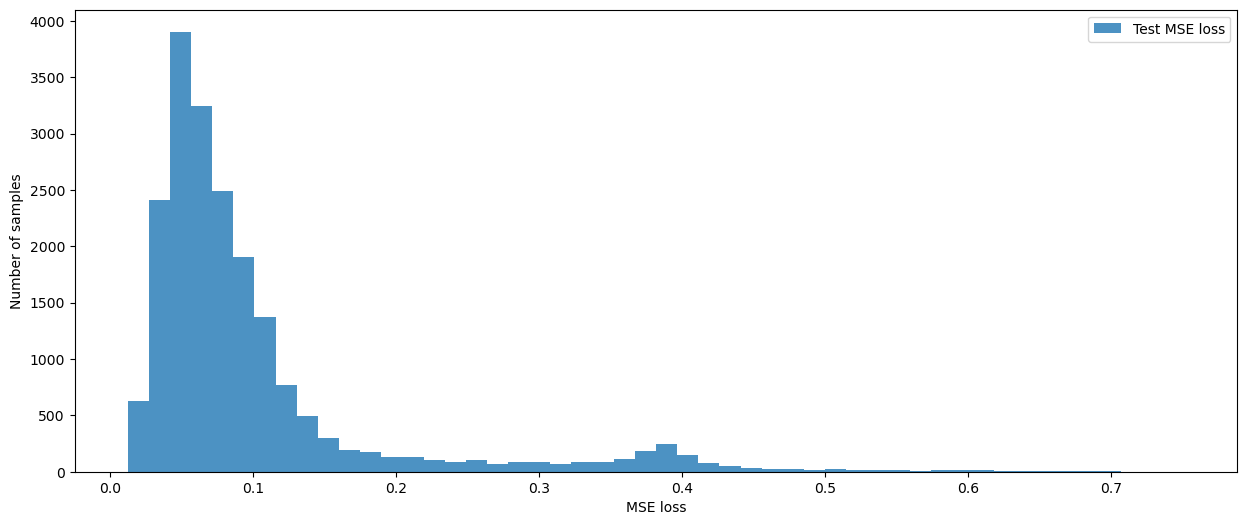

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

test_pred = model.predict(X_test)
test_mse = np.mean(np.power(test_pred - X_test, 2), axis=1)

# Plot histograms.
plt.figure(figsize=(15, 6))
plt.hist(test_mse, bins=50, alpha=0.8, label='Test MSE loss')
plt.xlabel("MSE loss")
plt.ylabel("Number of samples")
plt.legend()
plt.show()


In [29]:
len(test_mse[y_test==1])

10000

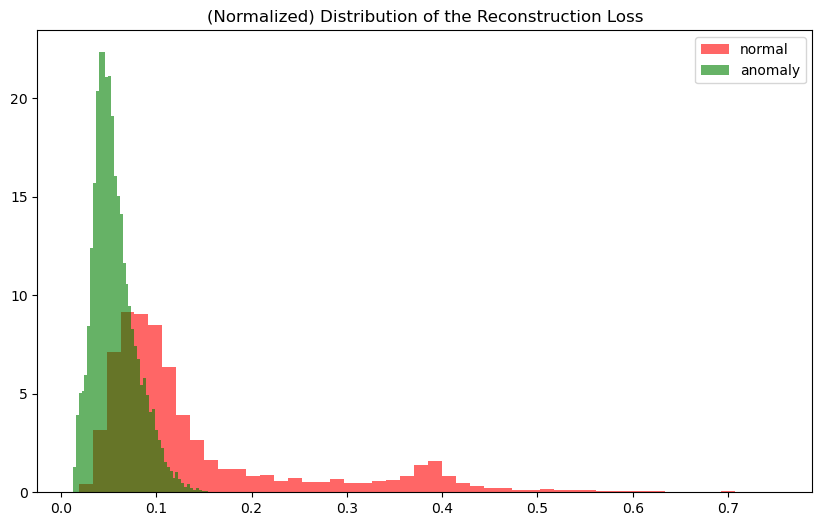

In [39]:
normal = test_mse[y_test==1]
anomaly = test_mse[y_test==-1]

fig, ax = plt.subplots(figsize=(10,6))

ax.hist(normal, bins=50, density=True, label="normal", alpha=.6, color="red")
ax.hist(anomaly, bins=50, density=True, label="anomaly", alpha=.6, color="green")

plt.title("Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

Threshold = 0.8 ?

In [43]:
len(anomaly)

10000

Best threshold: 0.07


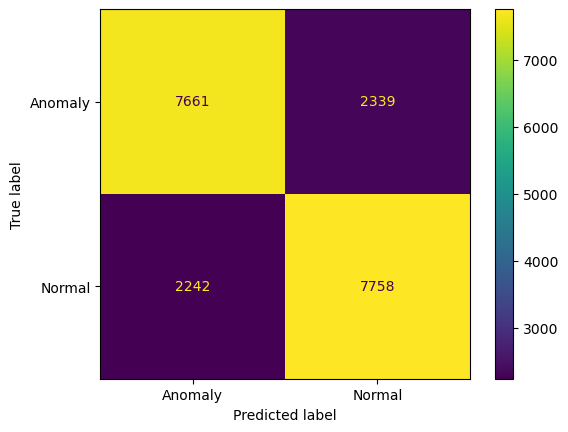

              precision    recall  f1-score   support

     Anomaly       0.77      0.77      0.77     10000
      Normal       0.77      0.78      0.77     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000



In [63]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def search_best_threshold():
    best_threshold = None
    best_f1 = 0

    for threshold in np.arange(0.05, 1.05, 0.02):  # Using numpy arange to include floating point numbers
        # Apply threshold to identify anomalies
        pred = np.where(test_mse < threshold, -1, 1)
        # Calculate F1 score for the current threshold
        f1 = f1_score(y_test, pred, pos_label=1)
        
        # Update the best F1 score and corresponding threshold
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    print("Best threshold:", best_threshold)
    return best_threshold

predicted_test = np.where(test_mse < search_best_threshold(), -1, 1)
# Create the confusion matrix

conf_matrix = confusion_matrix(y_test, predicted_test)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Anomaly", "Normal"])
disp.plot(values_format='.5g') # Set the format for the numeric values
plt.show()

# Calculate and display performance metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_test, target_names=["Anomaly", "Normal"]))
    



# Annx

In [37]:
THRESHOLD = 3

def mad_score(points):
    """https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

z_scores = mad_score(test_mse)
outliers = z_scores > THRESHOLD

In [38]:
print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} images [{np.sum(outliers)/np.size(z_scores):.2%}].")

Detected 2,173 outliers in a total of 20,000 images [10.87%].


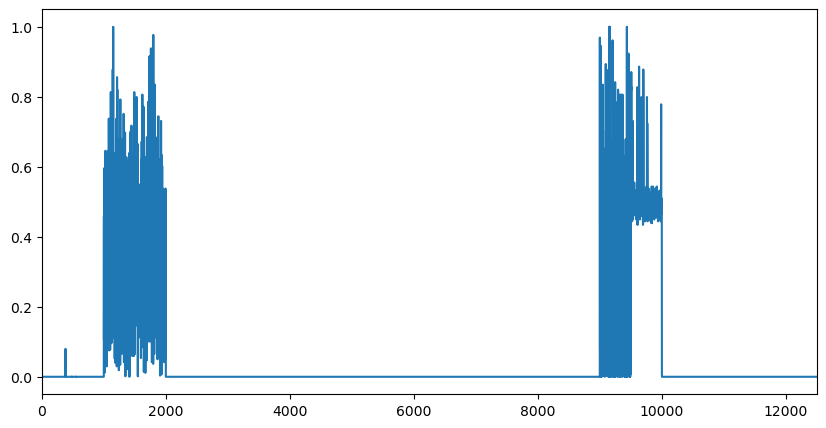

In [13]:
dist = X_test[:,0] - X_test_pred[:,0]
dist = pow(dist, 2)
dist = dist / np.max(dist)

# visualize the distribution
plt.figure(figsize=(10, 5))
plt.plot(dist)
plt.xlim(0, 12500)
plt.show()

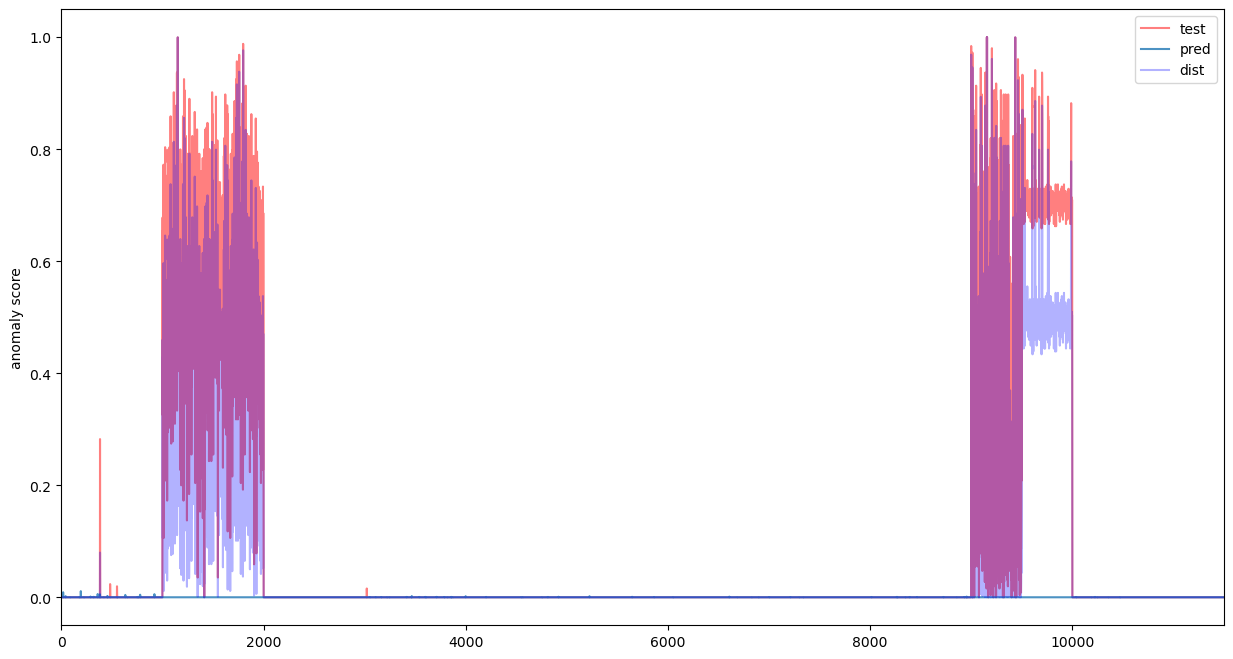

In [31]:
plt.figure(figsize=(15, 8))
plt.plot(X_test[0:,0], alpha=0.5, color='red' ,label='test')
plt.plot(X_test_pred[0:,0], alpha=0.8, label='pred')
plt.plot(dist[0:], alpha=0.3, color='blue',label='dist')
plt.legend()
plt.ylabel('anomaly score')
plt.xlim(0, 11500)
plt.show()

In [51]:
# Determine the threshold, annomalies
# According to modeling.ipynb, the threshold is (0.19281483 + 0.24185827) / 2 = 0.225
# 1 = normal, -1 = anomaly

threshold = round((0.19281483 + 0.24185827) / 2, 2)

pred_label_list = [ -1 if d > threshold else  0 for d in dist ]
pred_df = pd.DataFrame(pred_label_list, columns=['pred_label'])

new_test_df = pd.concat([test_df, pred_df], axis=1)
new_test_df = new_test_df.fillna(0)



In [52]:
new_test_df

,0,1,2,3,4,5,6,7,8,9,...,776,777,778,779,780,781,782,783,label,pred_label
0,0.0,0.380392,0.137255,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,0.0,0.000000,0.000000,0.0,0.0,0.094118,0.282353,0.000000,0.000000,0.000000,...,0.003922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,0.0,0.000000,0.000000,0.0,0.0,0.066667,0.541176,0.764706,0.992157,0.984314,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0
19996,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0
19997,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0
19998,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0


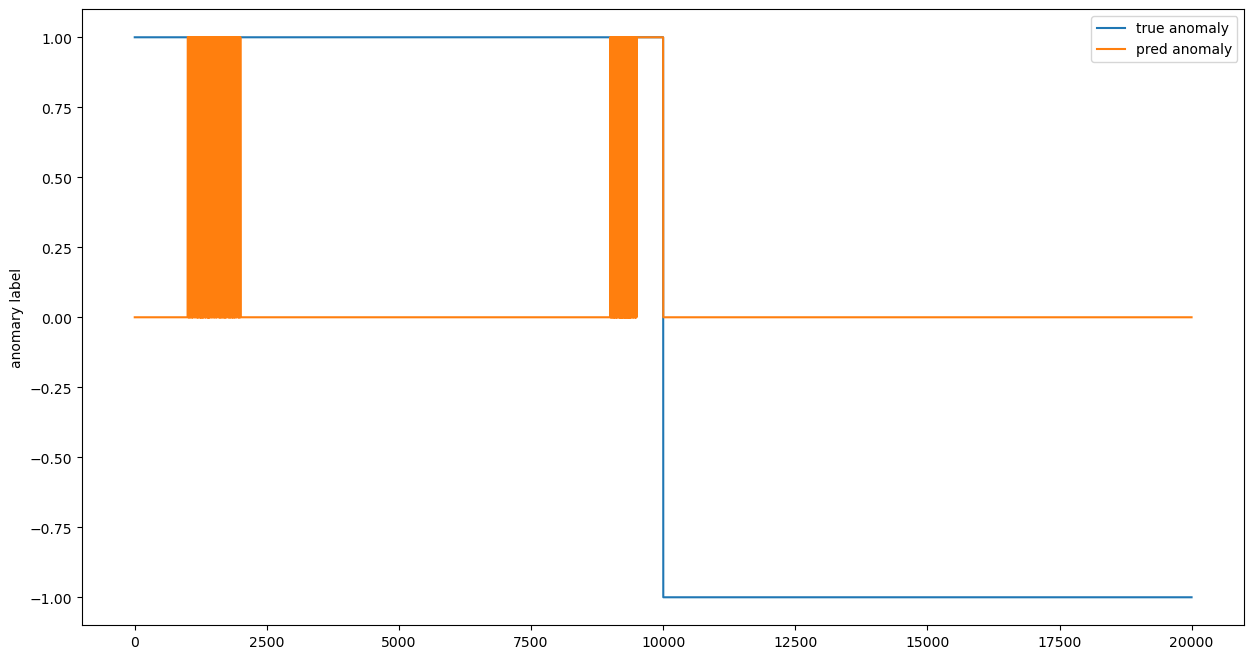

In [50]:
plt.figure(figsize=(15, 8))
plt.plot(new_test_df['label'], label ='true anomaly')
plt.plot(new_test_df['pred_label'], label='pred anomaly')
plt.ylabel('anomary label')
plt.legend()

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate distance and normalization
dist = np.square(X_test - X_test_pred)

# Visualize the distribution of distances
plt.figure(figsize=(10, 5))
plt.plot(dist)
plt.xlim(0, len(dist))
plt.title('Distribution of Normalized Squared Differences')
plt.show()

# Plot the test, prediction, and distance
plt.figure(figsize=(15, 8))
plt.plot(X_test[:, 0], alpha=0.5, color='red', label='Test')
plt.plot(X_test_pred[:, 0], alpha=0.8, label='Prediction')
plt.plot(dist, alpha=0.3, color='blue', label='Distance')
plt.xlim(0, len(X_test))
plt.legend()
plt.title('Test, Prediction, and Normalized Distance')
plt.show()

# Determine the threshold
threshold = 0.2    # round((0.19281483 + 0.24185827) / 2, 2)

# Label the anomalies
pred_label_list = [1 if d <= threshold else -1 for d in dist]
pred_df = pd.DataFrame(pred_label_list, columns=['pred_label'])

new_test_df = pd.concat([test_df, pred_df], axis=1)

# Plot the true anomaly vs predicted anomaly
plt.figure(figsize=(15, 8))
plt.plot(new_test_df['label'], label='True Anomaly', alpha=0.5)
plt.plot(new_test_df['pred_label'], label='Predicted Anomaly', alpha=0.5)
plt.title('True Anomaly vs Predicted Anomaly')
plt.legend()
plt.show()


KeyboardInterrupt: 

In [63]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score


print(confusion_matrix(X_test, X_test_pred))
print('accuracy_score: ', accuracy_score(X_test, X_test_pred))
print('precision_score: ', precision_score(X_test,X_test_pred))
print('recall_score: ', recall_score(X_test,X_test_pred))

ValueError: Classification metrics can't handle a mix of multiclass-multioutput and continuous-multioutput targets